30
['1645.18', '1667.99', '1549.89', '1667.99']
31
['1671.00', '1809.64', '1536.81', '1809.64']
30
['1816.80', '2128.61', '1800.91', '2025.94']
31
['2051.76', '2376.77', '2051.76', '2294.34']
31
['2279.94', '2618.33', '2211.17', '2344.00']


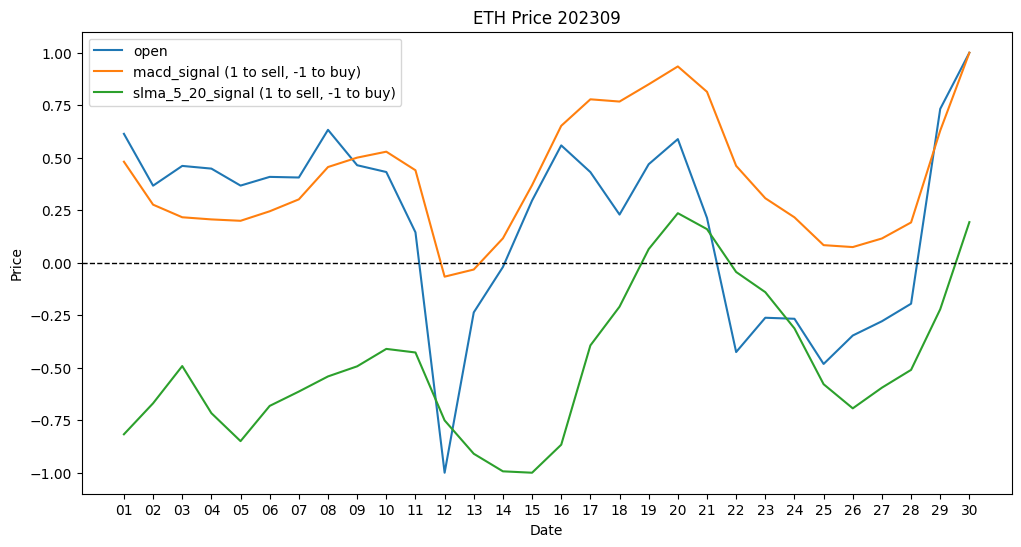

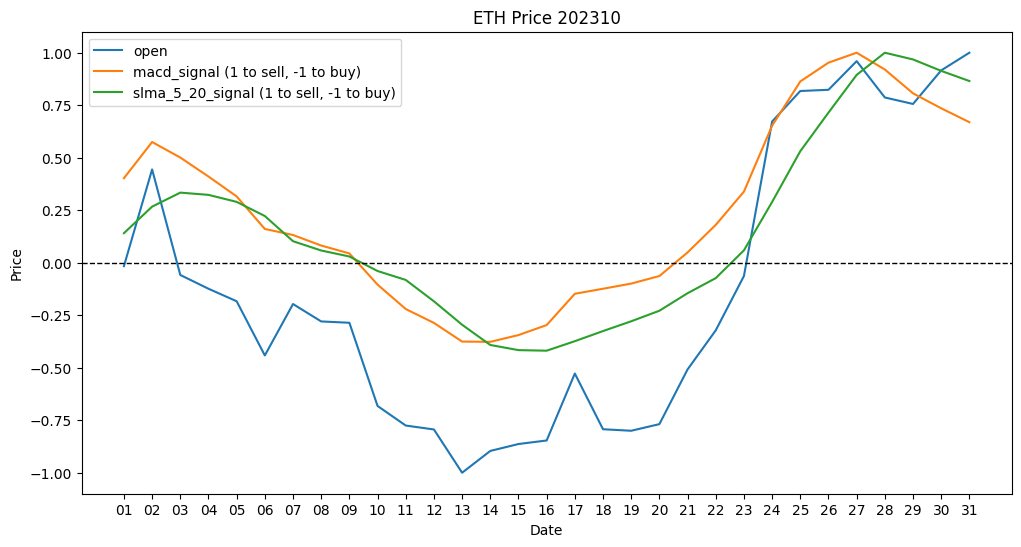

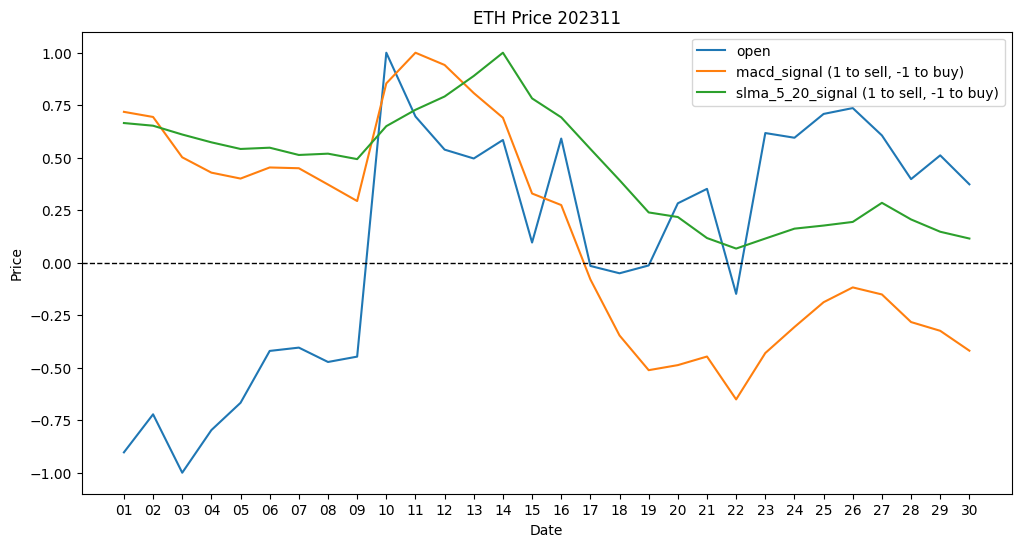

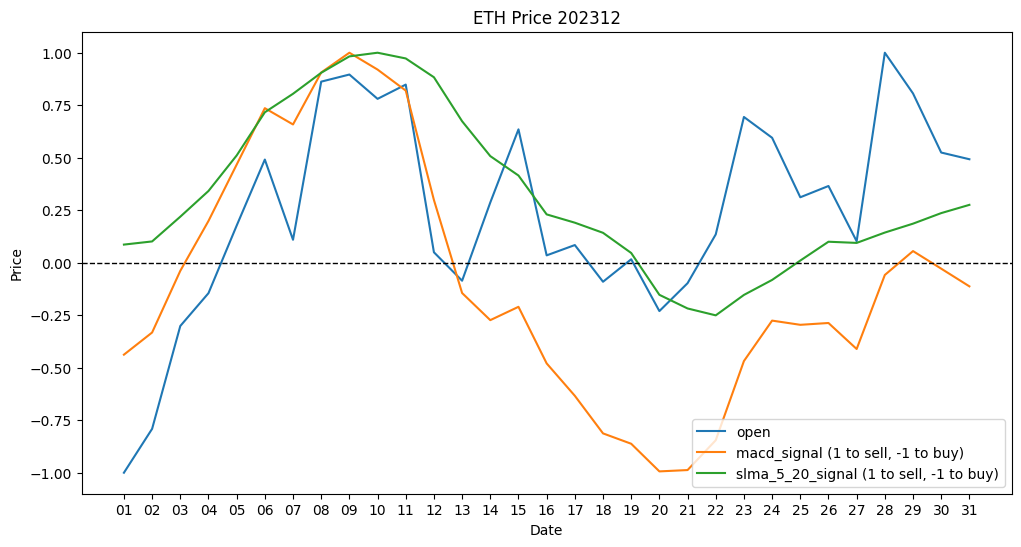

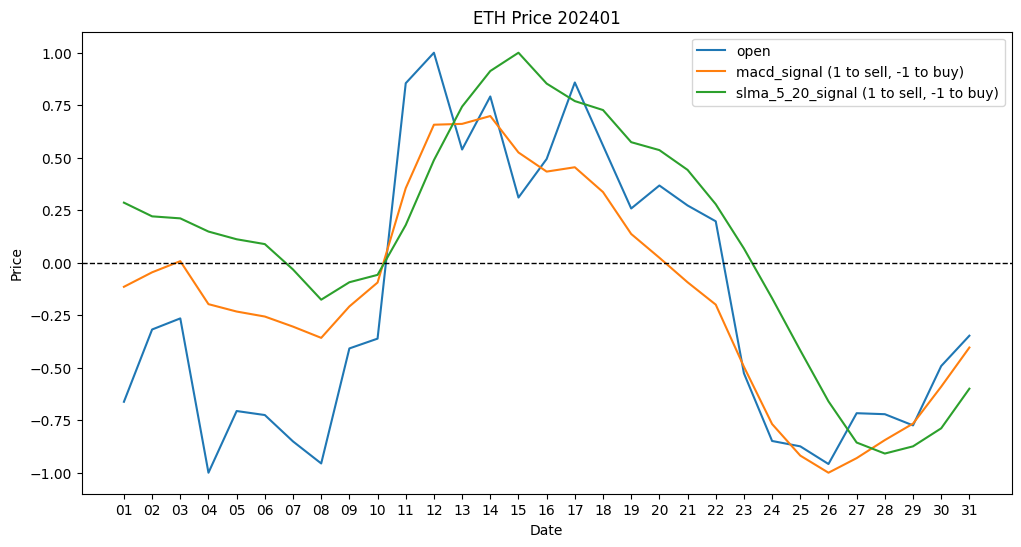

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

df = pd.read_csv('../data/eth_daily.csv')
df['date'] = pd.to_datetime(df['snapped_at'])
strategies = ['SMA', 'MACD']
sma_periods = [5, 10, 15, 20, 30]
starting_dates = ['2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01']
ending_dates = ['2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31']
yms_val = ['202310', '202312']
yms_test = ['202309', '202311', '202401']
yms_all = sorted(yms_val + yms_test)
GAS_LIMITS = 21000  # unit
GAS_PRICE = 70  # gwei
GAS_FEE = GAS_LIMITS * GAS_PRICE * 1e-9  # eth per txn
EX_RATE = 4e-3  # exchange fee = txn_amount * ex_rate
# GAS_FEE = 0
# EX_RATE = 0
starting_cash = 1_000_000
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# SMA
for period in sma_periods:
    df[f'SMA_{period}'] = df['open'].rolling(window=period).mean()

# MACD and Signal Line
df['EMA_12'] = df['open'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['open'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()


for starting_date, ending_date in zip(starting_dates, ending_dates):
    y, m, _ = starting_date.split('-')
    ym = f'{y}{m}'
    df_m = df[(df['date'] >= starting_date) & (df['date'] <= ending_date)]
    print(len(df_m))
    stat = [df_m.iloc[0]['open'], df_m['open'].max(), df_m['open'].min(), df_m.iloc[-1]['open']]
    print([f'{s:.2f}' for s in stat])
    df_m.to_csv(f'../data/eth_{ym}.csv', index=False)

    macd_signal = df_m['MACD'] - df_m['Signal_Line']
    macd_signal = macd_signal / macd_signal.abs().max()
    slma_5_20_signal = df_m['SMA_5'] - df_m['SMA_20']
    slma_5_20_signal = slma_5_20_signal / slma_5_20_signal.abs().max()
    dates = df_m['snapped_at'].apply(lambda x: x.split('-')[2].split(' ')[0])
    prices = df_m['open']
    prices = (prices - prices.min()) / (prices.max() - prices.min()) * 2 - 1
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, prices, label='open')
    ax.plot(dates, macd_signal, label='macd_signal (1 to sell, -1 to buy)')
    ax.plot(dates, slma_5_20_signal, label='slma_5_20_signal (1 to sell, -1 to buy)')
    # ax.plot(df_m['date'], df_m['SMA_5'], label='SMA_5')
    # ax.plot(df_m['date'], df_m['SMA_10'], label='SMA_10')
    # ax.plot(df_m['date'], df_m['SMA_15'], label='SMA_15')
    # ax.plot(df_m['date'], df_m['SMA_20'], label='SMA_20')
    # ax.plot(df_m['date'], df_m['SMA_30'], label='SMA_30')
    # ax.plot(df_m['date'], df_m['EMA_12'], label='EMA_12')
    # ax.plot(df_m['date'], df_m['EMA_26'], label='EMA_26')
    # ax.plot(df_m['date'], df_m['MACD'], label='MACD')
    # ax.plot(df_m['date'], df_m['Signal_Line'], label='Signal_Line')
    ax.axhline(0, color='black', lw=1, ls='--')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'ETH Price {ym}')
    ax.legend()

In [36]:
# first strategy: Simple MA 
# when the asset's open price is below the its SMA, and the volume is above the its SMA it's a buying signal, and vice versa for selling.

# second strategy: MACD
# MACD = 12-day EMA - 26-day EMA
# Signal Line = 9-day EMA of MACD
# When MACD crosses above the signal line, it's a buying signal, and vice versa for selling.

# third strategy: short and long strategy, moving average crossover (MAC) - If the short period SMA is below the long period SMA, it means that the trend is going down, so it's a sell signal, it's also known as the death cross.
# Otherwise, the trend is shiftting up, and it's a buy signal, it's also called the golden cross.
def run_strategy(strategy, file_path, sargs):
    df = pd.read_csv(file_path)
    # print(df)
    cash = starting_cash
    eth_held = 0  # Tracks the quantity of ETH held
    previous_signal = None  # Track the previous day signal
    
    # Iterate through each row in the DataFrame to simulate trading
    for index, row in df.iterrows():
        if index == len(df) - 1:  # no action on last day to avoid fee
            break
        open_price = row['open']

        if strategy == 'SMA':
            sma_column = sargs['column']
            ratio = sargs['ratio']
            current_signal = 'hold'
            if row['open'] > row[sma_column]:
                current_signal = 'buy'
            elif row['open'] < row[sma_column]:
                current_signal = 'sell'
            action = 0
            if current_signal != previous_signal:
                if current_signal == 'buy' and cash > 0:
                    action = ratio
                elif current_signal == 'sell' and eth_held > 0:
                    action = -ratio
            previous_signal = current_signal
                
        elif strategy == 'MACD':
            ratio = sargs['ratio']
            current_signal = 'hold'
            if row['MACD'] < row['Signal_Line']:
                current_signal = 'buy'
            elif row['MACD'] > row['Signal_Line']:
                current_signal = 'sell'
            action = 0
            if current_signal != previous_signal:
                if current_signal == 'buy' and cash > 0:
                    action = ratio
                elif current_signal == 'sell' and eth_held > 0:
                    action = -ratio
            previous_signal = current_signal

        elif strategy == 'MAC':
            ratio = sargs['ratio']
            current_signal = 'hold'
            if row[short] < row[long]:
                current_signal = 'buy'
            elif row[short] > row[long]:
                current_signal = 'sell'
            action = 0
            if current_signal != previous_signal:
                if current_signal == 'buy':
                    action = ratio
                elif current_signal == 'sell' and eth_held > 0:
                    action = -ratio
            
        elif strategy == 'buy':
            action = 0
            if cash > 0:
                action = 1

        else:
            raise ValueError('Invalid strategy')

        # uniform action entry
        if -1 <= action < 0 and eth_held > 0:  # Sell ETH
            eth_diff = abs(action) * eth_held
            cash_diff = eth_diff * open_price
            eth_held -= eth_diff
            cash += cash_diff
            cash -= GAS_FEE * open_price + cash_diff * EX_RATE
        elif 0 < action <= 1 and cash > 0:  # Buy ETH
            cash_diff = action * cash
            eth_diff = cash_diff / open_price
            cash -= cash_diff
            eth_held += eth_diff
            cash -= GAS_FEE * open_price + cash_diff * EX_RATE

    net_worth = cash + (eth_held * df.iloc[-1]['open'])
    roi = (net_worth / starting_cash) - 1
    return roi


# strategy = 'buy'
# roi_test = []
# for ym in yms_test:
#     file_path = f'../data/eth_{ym}.csv'
#     roi = run_strategy(strategy, file_path, {})
#     print(f'{strategy}, Time: {ym}, ROI: {roi*100:.2f}%')
#     roi_test.append(roi)
# roi_test = np.array(roi_test) * 100
# print(f'ROI: {roi_test.mean():.2f}+-{roi_test.std():.2f}')


# strategy = 'SMA'
# roi_val = defaultdict(float)
# for ym in yms_val:
#     file_path = f'../data/eth_{ym}.csv'
#     for period in sma_periods:
#         ratio = 1
#         # for ratio in np.arange(0.2, 1.1, 0.2):
#         column = f'SMA_{period}'
#         sargs = {'column': column, 'ratio': ratio}
#         roi = run_strategy(strategy, file_path, sargs)
#         print(f'{strategy}, Column: {column}, Time: {ym}, ROI: {roi*100:.2f}%')
#         roi_val[column] += roi
# print(roi_val)

# period = 30
# roi_test = []
# for ym in yms_test:
#     file_path = f'../data/eth_{ym}.csv'
#     ratio = 1
#     column = f'SMA_{period}'
#     sargs = {'column': column, 'ratio': ratio}
#     roi = run_strategy(strategy, file_path, sargs)
#     print(f'{strategy}, Column: {column}, Time: {ym}, ROI: {roi*100:.2f}%')
#     roi_test.append(roi)
# roi_test = np.array(roi_test) * 100
# print(f'ROI: {roi_test.mean():.2f}+-{roi_test.std():.2f}')


print()
strategy = 'MACD'
roi_test = []
# for ym in yms_test:
for ym in yms_all:
# for ym in ['202309']:
    file_path = f'../data/eth_{ym}.csv'
    ratio = 1
    # for ratio in np.arange(0.2, 1.1, 0.2):
    sargs = {'ratio': ratio}
    roi = run_strategy(strategy, file_path, sargs)
    print(f'{strategy}, Time: {ym}, ROI: {roi*100:.2f}%')
    roi_test.append(roi)
roi_test = np.array(roi_test) * 100
print(f'ROI: {roi_test.mean():.2f}+-{roi_test.std():.2f}')


# print()
# strategy = 'MAC'
# roi_val = defaultdict(float)
# for ym in yms_val:
# # for ym in yms_all:
#     file_path = f'../data/eth_{ym}.csv'
#     ratio = 1
#     for i in range(len(sma_periods)-1):
#         for j in range(i+1, len(sma_periods)):
#             short = f'SMA_{sma_periods[i]}'
#             long = f'SMA_{sma_periods[j]}'
#             sargs = {'ratio': 1, 'short': short, 'long': long}
#             roi = run_strategy(strategy, file_path, sargs)
#             print(f'{strategy}, Short: {short}, Long: {long}, Time: {ym}, ROI: {roi*100:.2f}%')
#             roi_val[(short, long)] += roi
# print(roi_val)

# # short, long = 'SMA_10', 'SMA_20'
# short, long = 'SMA_5', 'SMA_20'
# roi_test = []
# for ym in yms_test:
#     file_path = f'../data/eth_{ym}.csv'
#     ratio = 1
#     sargs = {'ratio': ratio, 'short': short, 'long': long}
#     roi = run_strategy(strategy, file_path, sargs)
#     print(f'{strategy}, Short: {short}, Long: {long}, Time: {ym}, ROI: {roi*100:.2f}%')
#     roi_test.append(roi)
# roi_test = np.array(roi_test) * 100
# print(f'ROI: {roi_test.mean():.2f}+-{roi_test.std():.2f}')


MACD, Time: 202309, ROI: 2.92%
MACD, Time: 202310, ROI: 0.70%
MACD, Time: 202311, ROI: 2.85%
MACD, Time: 202312, ROI: 11.35%
MACD, Time: 202401, ROI: 12.80%
ROI: 6.12+-4.95


In [7]:
# mean std
import numpy as np
arr = np.array([0.005589002799535114,0,-0.0302623800029167]) * 100
# arr = np.array([0.0766651034332797,0.024811663899072522,-0.015567128797595364]) * 100
# arr = np.array([0.1572889074007382,-0.017281564002268768,0.020156207034912388]) * 100
arr = np.array([0.005589002799535114,0.0,0.0]) * 100
arr = np.array([0.1748561102270645,0.0,0.03332089922972514]) * 100

print(arr.tolist())
print(f'ROI: {arr.mean():.2f}+-{arr.std():.2f}')

[17.48561102270645, 0.0, 3.3320899229725143]
ROI: 6.94+-7.58


In [13]:
arr = np.array([4.84,1.32,5.64,6.19,6.94])
arr/1e2*1e6

array([48400., 13200., 56400., 61900., 69400.])